In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import chi2_contingency
import seaborn as sns


In [3]:
segment = pd.read_csv(r"data\brutes\Données_CCF_PAR_SEGMENT.csv",sep=";")
segment.head()
macro = pd.read_excel(r"data\brutes\historique_macro_variables_projet_CCF_FowardLooking_IFRS9.xlsx")
macro["date_dernier_mois"] = pd.to_datetime(macro["date_dernier_mois"], format="%Y-%m")
macro["cod_prd_ref"] = macro["date_dernier_mois"].dt.year.astype(str) + "T" + macro["date_dernier_mois"].dt.quarter.astype(str)
macro.drop(columns=["date_dernier_mois"], inplace=True)
macro = macro[macro["cod_prd_ref"] >= '2009T1']


FileNotFoundError: [Errno 2] No such file or directory: 'data\\brutes\\Données_CCF_PAR_SEGMENT.csv'

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle_ipl, trend_ipl = hpfilter(macro["IPL_diff1"].dropna(), lamb=1600)
macro["IPL_diff1_hp"] = cycle_ipl


In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

segments_hp = [2, 3]

for i in segments_hp:
    segment_i = segment[segment["note_ref"] == i].copy()

    try:
        series = segment_i["Indicateur_moyen_Brut"].str.replace(",", ".").astype(float).dropna()

        cycle, trend = hpfilter(series, lamb=1600)
        segment.loc[segment["note_ref"] == i, "cycle_hp"] = cycle.values

        print(f"✅ HP filter appliqué au segment {i}")
    except Exception as e:
        print(f"❌ Erreur pour le segment {i} : {e}")


✅ HP filter appliqué au segment 2
✅ HP filter appliqué au segment 3


In [ ]:
segment["Indicateur_moyen_Brut"] = segment.apply(
    lambda row: row["cycle_hp"] if row["note_ref"] in [2, 3] else row["Indicateur_moyen_Brut"],
    axis=1
)


In [ ]:
segment["cod_prd_ref"] = segment["cod_prd_ref"].astype(str).str.strip()
macro["cod_prd_ref"] = macro["cod_prd_ref"].astype(str).str.strip()

In [ ]:
df_merged = pd.merge(segment, macro, on="cod_prd_ref", how="left")
colonnes_a_supprimer = ['cycle_hp', 'PIB_diff1','IPL', 'TCH', 'Inflation', 'IPL_diff1']
df = df_merged.drop(columns=colonnes_a_supprimer)
df.columns

Index(['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote',
       'PourcNoteCohorte', 'PourcNoteCohorte5', 'PIB', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [ ]:
segment_1 =df[df["note_ref"] == 1].copy()
segment_2 =df[df["note_ref"] == 2].copy()
segment_3 =df[df["note_ref"] == 3].copy()
segment_4 =df[df["note_ref"] == 4].copy()
segment_5 =df[df["note_ref"] == 5].copy()

In [ ]:
df.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",-1.286788,0.9,-0.697982,-2.287187
1,2009T1,2,0.139372,"0,0150016761649346","0,13987106856808","0,237794752573896",-1.286788,0.9,-0.697982,-2.287187
2,2009T1,3,-0.001619,"0,0188878742730812","0,0767728071889041","0,130521421454666",-1.286788,0.9,-0.697982,-2.287187
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",-1.286788,0.9,-0.697982,-2.287187
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682",-1.286788,0.9,-0.697982,-2.287187


In [ ]:
def enrichir_variables_macro(df):
    """
    Applique un enrichissement macroéconomique complet :
    - lags (1 et 2),
    - moyennes mobiles (3 et 5 périodes),
    - interactions,
    - puissances (carrés),
    - suppressions des NaN critiques.
    """
    df = df.copy()

    # === Lags simples ===
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)

    df["PIB_lag2"] = df["PIB"].shift(2)
    df["TCH_diff1_lag2"] = df["TCH_diff1"].shift(2)
    df["Inflation_diff1_lag2"] = df["Inflation_diff1"].shift(2)
    df["IPL_diff1_hp_lag2"] = df["IPL_diff1_hp"].shift(2)

    # === Moyennes mobiles ===
    df["PIB_ma3"] = df["PIB"].rolling(window=3).mean()
    df["TCH_ma3"] = df["TCH_diff1"].rolling(window=3).mean()
    df["Inflation_ma3"] = df["Inflation_diff1"].rolling(window=3).mean()
    df["IPL_ma3"] = df["IPL_diff1_hp"].rolling(window=3).mean()

    df["PIB_ma5"] = df["PIB"].rolling(window=5).mean()
    df["TCH_ma5"] = df["TCH_diff1"].rolling(window=5).mean()
    df["Inflation_ma5"] = df["Inflation_diff1"].rolling(window=5).mean()
    df["IPL_ma5"] = df["IPL_diff1_hp"].rolling(window=5).mean()

    # === Puissances ===
    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    # === Interactions ===
    df["PIB_x_TCH"] = df["PIB"] * df["TCH_diff1"]
    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]

    df["PIB_x_TCH_ma3"] = df["PIB"] * df["TCH_diff1"].rolling(3).mean()

    # === Affichage diagnostique ===
    print("🧪 Enrichissement des variables macro effectué.")
    print("Nombre de lignes avant suppression :", len(df))
    print("Nombre de NaN par colonne :")
    print(df.isna().sum())

    # # Colonnes critiques pour modélisation
    # colonnes_critiques = [
    #     "Indicateur_moyen_Brut", "PIB", "TCH_diff1", "Inflation_diff1", "IPL_diff1_hp",
    #     "PIB_lag1", "TCH_diff1_lag1", "Inflation_diff1_lag1", "IPL_diff1_hp_lag1",
    #     "PIB_ma3", "TCH_ma3", "Inflation_ma3", "IPL_ma3"
    # ]
    # df = df.dropna(subset=colonnes_critiques)

    return df


In [ ]:
df_plus= enrichir_variables_macro(df)

🧪 Enrichissement des variables macro effectué.
Nombre de lignes avant suppression : 360
Nombre de NaN par colonne :
cod_prd_ref                0
note_ref                   0
Indicateur_moyen_Brut      0
PourcNote                  0
PourcNoteCohorte           0
PourcNoteCohorte5          0
PIB                        0
TCH_diff1                  0
Inflation_diff1            0
IPL_diff1_hp               0
PIB_lag1                   1
TCH_diff1_lag1             1
Inflation_diff1_lag1       1
IPL_diff1_hp_lag1          1
PIB_lag2                   2
TCH_diff1_lag2             2
Inflation_diff1_lag2       2
IPL_diff1_hp_lag2          2
PIB_ma3                    2
TCH_ma3                    2
Inflation_ma3              2
IPL_ma3                    2
PIB_ma5                    4
TCH_ma5                    4
Inflation_ma5              4
IPL_ma5                    4
PIB_squared                0
TCH_diff1_squared          0
Inflation_diff1_squared    0
IPL_diff1_hp_squared       0
PIB_x_TCH     

In [ ]:
df_plus.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp,...,IPL_ma5,PIB_squared,TCH_diff1_squared,Inflation_diff1_squared,IPL_diff1_hp_squared,PIB_x_TCH,PIB_x_Inflation,TCH_x_IPL,Inflation_x_IPL,PIB_x_TCH_ma3
0,2009T1,1,"0,451962798","0,0128162511542013","0,0677866770853682","0,115244104948522",-1.286788,0.9,-0.697982,-2.287187,...,NaN,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,NaN
1,2009T1,2,0.139372,"0,0150016761649346","0,13987106856808","0,237794752573896",-1.286788,0.9,-0.697982,-2.287187,...,NaN,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,NaN
2,2009T1,3,-0.001619,"0,0188878742730812","0,0767728071889041","0,130521421454666",-1.286788,0.9,-0.697982,-2.287187,...,NaN,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,-1.158109
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",-1.286788,0.9,-0.697982,-2.287187,...,NaN,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,-1.158109
4,2009T1,5,"1,093202854","0,0221397186552676","0,2539558507521","0,431750249086682",-1.286788,0.9,-0.697982,-2.287187,...,-2.287187,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,-1.158109


In [ ]:
segment_1 = df_plus[df_plus["note_ref"] == 1].copy()
segment_2 = df_plus[df_plus["note_ref"] == 2].copy()
segment_3 = df_plus[df_plus["note_ref"] == 3].copy()
segment_4 = df_plus[df_plus["note_ref"] == 4].copy()
segment_5 = df_plus[df_plus["note_ref"] == 5].copy()


In [ ]:
def afficher_top5_corrélées(df_segment, nom_segment, cible="Indicateur_moyen_Brut"):
    df_num = df_segment.select_dtypes(include='number')
    
    if cible not in df_num.columns:
        print(f"⚠️ La variable cible '{cible}' est absente de {nom_segment}.")
        return

    corr_matrix = df_num.corr()
    corr_target = corr_matrix[cible].drop(labels=[cible])  # exclure la cible elle-même

    top5 = corr_target.abs().sort_values(ascending=False).head(5)
    top5 = corr_target.loc[top5.index]  # garder les vraies valeurs signées

    print(f"\n🔍 {nom_segment} – Top 5 variables les plus corrélées à '{cible}'")
    print(top5.round(3))


In [ ]:
segment_4.head()

,cod_prd_ref,note_ref,Indicateur_moyen_Brut,PourcNote,PourcNoteCohorte,PourcNoteCohorte5,PIB,TCH_diff1,Inflation_diff1,IPL_diff1_hp,...,IPL_ma5,PIB_squared,TCH_diff1_squared,Inflation_diff1_squared,IPL_diff1_hp_squared,PIB_x_TCH,PIB_x_Inflation,TCH_x_IPL,Inflation_x_IPL,PIB_x_TCH_ma3
3,2009T1,4,"1,275863582","0,0148540805032912","0,0498144168782965","0,0846894719362338",-1.286788,0.9,-0.697982,-2.287187,...,NaN,1.655822,0.81,0.487179,5.231224,-1.158109,0.898155,-2.058468,1.596416,-1.158109
9,2009T2,4,"0,967390423","0,0191646764140502","0,0611069836552749","0,101920693928129",-2.243102,0.5,-0.791262,-2.418131,...,-2.391942,5.031506,0.25,0.626095,5.847359,-1.121551,1.774881,-1.209066,1.913375,-1.121551
15,2009T3,4,"1,052081375","0,0194559328945069","0,0538796580093563","0,091206990715456",-3.012266,0.0,0.126594,-1.657648,...,-1.809745,9.073746,0.00,0.016026,2.747798,-0.000000,-0.381334,-0.000000,-0.209848,-0.000000
21,2009T4,4,"0,936314848","0,0215529795537951","0,0589923469387755","0,0989834135901552",-2.782833,0.4,1.277447,0.100615,...,-0.251038,7.744157,0.16,1.631870,0.010123,-1.113133,-3.554920,0.040246,0.128530,-1.113133
27,2010T1,4,"1,168514962","0,021203471777247","0,0601156069364162","0,103970294201657",-1.517665,-0.2,0.675389,1.873299,...,1.518762,2.303308,0.04,0.456150,3.509248,0.303533,-1.025015,-0.374660,1.265206,0.303533


In [ ]:
for seg in [segment_1, segment_2, segment_3, segment_4, segment_5]:
    seg["Indicateur_moyen_Brut"] = (
        seg["Indicateur_moyen_Brut"]
        .astype(str)
        .str.replace(",", ".")
        .astype(float)
    )

In [ ]:
afficher_top5_corrélées(segment_1, "Segment 1")
afficher_top5_corrélées(segment_2, "Segment 2")
afficher_top5_corrélées(segment_3, "Segment 3")
afficher_top5_corrélées(segment_4, "Segment 4")
afficher_top5_corrélées(segment_5, "Segment 5")


🔍 Segment 1 – Top 5 variables les plus corrélées à 'Indicateur_moyen_Brut'
IPL_diff1_hp_squared    0.493
TCH_x_IPL              -0.360
PIB_squared            -0.339
TCH_ma3                 0.304
TCH_ma5                 0.278
Name: Indicateur_moyen_Brut, dtype: float64

🔍 Segment 2 – Top 5 variables les plus corrélées à 'Indicateur_moyen_Brut'
PIB_lag2          0.484
PIB_ma5           0.437
PIB_ma3           0.390
TCH_diff1_lag2   -0.346
PIB_squared      -0.285
Name: Indicateur_moyen_Brut, dtype: float64

🔍 Segment 3 – Top 5 variables les plus corrélées à 'Indicateur_moyen_Brut'
Inflation_diff1_squared    0.239
PIB_x_Inflation            0.216
PIB_ma5                    0.216
PIB_lag1                   0.188
PIB                        0.188
Name: Indicateur_moyen_Brut, dtype: float64

🔍 Segment 4 – Top 5 variables les plus corrélées à 'Indicateur_moyen_Brut'
IPL_diff1_hp_squared    0.468
TCH_x_IPL              -0.463
Inflation_x_IPL         0.393
TCH_diff1_lag2          0.315
TCH_diff1

In [ ]:
print(segment_1.columns.tolist())


['cod_prd_ref', 'note_ref', 'Indicateur_moyen_Brut', 'PourcNote', 'PourcNoteCohorte', 'PourcNoteCohorte5', 'PIB', 'TCH_diff1', 'Inflation_diff1', 'IPL_diff1_hp', 'PIB_lag1', 'TCH_diff1_lag1', 'Inflation_diff1_lag1', 'IPL_diff1_hp_lag1', 'PIB_lag2', 'TCH_diff1_lag2', 'Inflation_diff1_lag2', 'IPL_diff1_hp_lag2', 'PIB_ma3', 'TCH_ma3', 'Inflation_ma3', 'IPL_ma3', 'PIB_ma5', 'TCH_ma5', 'Inflation_ma5', 'IPL_ma5', 'PIB_squared', 'TCH_diff1_squared', 'Inflation_diff1_squared', 'IPL_diff1_hp_squared', 'PIB_x_TCH', 'PIB_x_Inflation', 'TCH_x_IPL', 'Inflation_x_IPL', 'PIB_x_TCH_ma3']


In [ ]:
afficher_top5_corrélées(segment_1, "Segment 1", cible="Indicateur_moyen_Brut")



🔍 Segment 1 – Top 5 variables les plus corrélées à 'Indicateur_moyen_Brut'
IPL_diff1_hp_squared    0.493
TCH_x_IPL              -0.360
PIB_squared            -0.339
TCH_ma3                 0.304
TCH_ma5                 0.278
Name: Indicateur_moyen_Brut, dtype: float64


In [ ]:
print("Indicateur_moyen_Brut" in segment_1.columns)  # doit afficher True


True


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, jarque_bera

def modele_complet(df, cible="Indicateur_moyen_Brut", top_n=5):
    print(f"\n📊 Régression segment – Variable cible : {cible}")
    
    # --- Nettoyage de la cible ---
    df = df.copy()
    if cible in df.columns:
        df[cible] = df[cible].astype(str).str.replace(",", ".").astype(float)
    else:
        print(f"❌ Colonne cible '{cible}' absente.")
        return None

    df = df.dropna(subset=[cible])
    
    # --- Corrélation et sélection des variables ---
    df_num = df.select_dtypes(include='number')
    if cible not in df_num.columns:
        print(f"❌ Cible '{cible}' n'est pas numérique après conversion.")
        return None

    corr = df_num.corr()[cible].drop(labels=[cible])
    top_features = corr.abs().sort_values(ascending=False).head(top_n).index.tolist()
    print(f"🎯 Variables sélectionnées : {top_features}")

    # --- Construction des données X/y ---
    X = df[top_features].astype(float)
    y = df[cible].astype(float)
    Xy = pd.concat([X, y], axis=1).dropna()
    X = Xy[top_features]
    y = Xy[cible]

    if len(X) < 10:
        print("❌ Trop peu d'observations après nettoyage.")
        return None

    # --- OLS ---
    X_const = sm.add_constant(X)
    model_ols = sm.OLS(y, X_const).fit()
    print("\n📈 Résultats OLS :")
    print(model_ols.summary())

    # --- Hypothèses MCO ---
    print("\n🔎 Vérification des hypothèses MCO")
    dw = durbin_watson(model_ols.resid)
    bp_test = het_breuschpagan(model_ols.resid, model_ols.model.exog)
    shap_p = shapiro(model_ols.resid)[1]
    jb_p = jarque_bera(model_ols.resid)[1]

    print(f"Durbin-Watson : {dw:.3f} → {'✅' if 1.5 <= dw <= 2.5 else '❌'}")
    print(f"Breusch-Pagan p : {bp_test[1]:.4f} → {'✅' if bp_test[1] > 0.05 else '❌'}")
    print(f"Shapiro-Wilk p : {shap_p:.4f} → {'✅' if shap_p > 0.05 else '❌'}")
    print(f"Jarque-Bera p  : {jb_p:.4f} → {'✅' if jb_p > 0.05 else '❌'}")

    # --- Modèles alternatifs ---
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 20)).fit(X, y)
    lasso = LassoCV(alphas=np.logspace(-3, 3, 20), max_iter=5000).fit(X, y)
    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)

    r2_ols = model_ols.rsquared
    r2_ridge = r2_score(y, ridge.predict(X))
    r2_lasso = r2_score(y, lasso.predict(X))
    r2_rf = r2_score(y, rf.predict(X))

    print("\n📊 R² comparés :")
    print(f"OLS    : {r2_ols:.3f}")
    print(f"Ridge  : {r2_ridge:.3f}")
    print(f"Lasso  : {r2_lasso:.3f}")
    print(f"RF     : {r2_rf:.3f}")

    best_model = max(
        [("OLS", r2_ols), ("Ridge", r2_ridge), ("Lasso", r2_lasso), ("RF", r2_rf)],
        key=lambda x: x[1]
    )

    print(f"\n✅ Meilleur modèle : {best_model[0]} (R² = {best_model[1]:.3f})")

    return {
        "best_model": best_model[0],
        "r2_scores": {"OLS": r2_ols, "Ridge": r2_ridge, "Lasso": r2_lasso, "RF": r2_rf},
        "mco_diagnostics": {
            "DW": dw, "BP_p": bp_test[1], "Shapiro_p": shap_p, "JB_p": jb_p
        },
        "top_features": top_features,
        "model_ols": model_ols,
        "model_ridge": ridge,
        "model_lasso": lasso,
        "model_rf": rf
    }


In [ ]:
modele_complet(segment_1)  # ou segment_2, etc.



📊 Régression segment – Variable cible : Indicateur_moyen_Brut
🎯 Variables sélectionnées : ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'PIB_squared', 'TCH_ma3', 'TCH_ma5']

📈 Résultats OLS :
                              OLS Regression Results                             
Dep. Variable:     Indicateur_moyen_Brut   R-squared:                       0.362
Model:                               OLS   Adj. R-squared:                  0.302
Method:                    Least Squares   F-statistic:                     6.024
Date:                   Sun, 25 May 2025   Prob (F-statistic):           0.000175
Time:                           02:44:02   Log-Likelihood:                 60.942
No. Observations:                     59   AIC:                            -109.9
Df Residuals:                         53   BIC:                            -97.42
Df Model:                              5                                         
Covariance Type:               nonrobust                                     

{'best_model': 'RF',
 'r2_scores': {'OLS': np.float64(0.36235053851235555),
  'Ridge': 0.33006414149394736,
  'Lasso': 0.3462841232167778,
  'RF': 0.8917943989905022},
 'mco_diagnostics': {'DW': np.float64(1.121050218816468),
  'BP_p': np.float64(0.3201253641081218),
  'Shapiro_p': np.float64(0.2476911519137539),
  'JB_p': np.float64(0.4717508823767096)},
 'top_features': ['IPL_diff1_hp_squared',
  'TCH_x_IPL',
  'PIB_squared',
  'TCH_ma3',
  'TCH_ma5'],
 'model_ols': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x247b5f45890>,
 'model_ridge': RidgeCV(alphas=array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
        1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
        3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
        6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
        1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])),
 'model_lasso': LassoCV(alphas=array([1.00000000e-03,

In [ ]:
# Assure-toi d’avoir déjà défini `modele_complet()` avant

# Dictionnaire de tes segments
segments = {
    1: segment_1,
    2: segment_2,
    3: segment_3,
    4: segment_4,
    5: segment_5
}

# Résultats stockés ici
résultats = []

# Boucle sur chaque segment
for i in range(1, 6):
    print(f"\n{'='*30}\n🔁 Traitement du segment {i}")
    result = modele_complet(segments[i])

    if result is not None:
        résultats.append({
            "Segment": i,
            "Modèle_retenu": result["best_model"],
            "R2_OLS": result["r2_scores"]["OLS"],
            "R2_Ridge": result["r2_scores"]["Ridge"],
            "R2_Lasso": result["r2_scores"]["Lasso"],
            "R2_RF": result["r2_scores"]["RF"],
            "DW": result["mco_diagnostics"]["DW"],
            "BP_p": result["mco_diagnostics"]["BP_p"],
            "Shapiro_p": result["mco_diagnostics"]["Shapiro_p"],
            "JB_p": result["mco_diagnostics"]["JB_p"],
            "Top_features": ", ".join(result["top_features"])
        })
    else:
        print(f"⚠️ Aucun modèle calculable pour le segment {i}.")

# Résumé final
résumé_df = pd.DataFrame(résultats)
print("\n📊 Résumé comparatif des segments :")
display(résumé_df.round(3))



🔁 Traitement du segment 1

📊 Régression segment – Variable cible : Indicateur_moyen_Brut
🎯 Variables sélectionnées : ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'PIB_squared', 'TCH_ma3', 'TCH_ma5']

📈 Résultats OLS :
                              OLS Regression Results                             
Dep. Variable:     Indicateur_moyen_Brut   R-squared:                       0.362
Model:                               OLS   Adj. R-squared:                  0.302
Method:                    Least Squares   F-statistic:                     6.024
Date:                   Sun, 25 May 2025   Prob (F-statistic):           0.000175
Time:                           02:44:02   Log-Likelihood:                 60.942
No. Observations:                     59   AIC:                            -109.9
Df Residuals:                         53   BIC:                            -97.42
Df Model:                              5                                         
Covariance Type:               nonrobust          

,Segment,Modèle_retenu,R2_OLS,R2_Ridge,R2_Lasso,R2_RF,DW,BP_p,Shapiro_p,JB_p,Top_features
0,1,RF,0.362,0.330,0.346,0.892,1.121,0.320,0.248,0.472,"IPL_diff1_hp_squared, TCH_x_IPL, PIB_squared, ..."
1,2,RF,0.364,0.362,0.253,0.886,1.959,0.836,0.864,0.895,"PIB_lag2, PIB_ma5, PIB_ma3, TCH_diff1_lag2, PI..."
2,3,RF,0.098,0.042,0.084,0.822,2.136,0.411,0.558,0.595,"Inflation_diff1_squared, PIB_x_Inflation, PIB_..."
3,4,RF,0.344,0.338,0.340,0.883,1.494,0.855,0.664,0.990,"IPL_diff1_hp_squared, TCH_x_IPL, Inflation_x_I..."
4,5,RF,0.160,0.154,0.156,0.844,1.254,0.975,0.000,0.000,"PIB_squared, TCH_x_IPL, IPL_diff1_hp_squared, ..."


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

predictions_by_segment = {}

for i, df in segments.items():
    df = df.copy()
    
    # Nettoyage de la cible
    df["Indicateur_moyen_Brut"] = df["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df = df.dropna(subset=["Indicateur_moyen_Brut"])

    # Sélection des top features
    df_num = df.select_dtypes(include='number')
    corr = df_num.corr()["Indicateur_moyen_Brut"].drop("Indicateur_moyen_Brut")
    top_features = corr.abs().sort_values(ascending=False).head(5).index.tolist()

    # Construction X / y
    X = df[top_features].astype(float)
    y = df["Indicateur_moyen_Brut"]
    Xy = pd.concat([X, y], axis=1).dropna()
    X = Xy[top_features]
    y = Xy["Indicateur_moyen_Brut"]

    if len(X) < 10:
        print(f"⚠️ Trop peu de données pour le segment {i}")
        continue

    # Entraînement Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    y_pred = model.predict(X)

    # Sauvegarde des prédictions
    df_result = df.loc[X.index].copy()
    df_result["prediction"] = y_pred
    predictions_by_segment[i] = df_result

    print(f"✅ Segment {i} – R² = {r2_score(y, y_pred):.3f} – Top features : {top_features}")


✅ Segment 1 – R² = 0.892 – Top features : ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'PIB_squared', 'TCH_ma3', 'TCH_ma5']
✅ Segment 2 – R² = 0.886 – Top features : ['PIB_lag2', 'PIB_ma5', 'PIB_ma3', 'TCH_diff1_lag2', 'PIB_squared']
✅ Segment 3 – R² = 0.822 – Top features : ['Inflation_diff1_squared', 'PIB_x_Inflation', 'PIB_ma5', 'PIB_lag1', 'PIB']
✅ Segment 4 – R² = 0.883 – Top features : ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'Inflation_x_IPL', 'TCH_diff1_lag2', 'TCH_diff1']
✅ Segment 5 – R² = 0.844 – Top features : ['PIB_squared', 'TCH_x_IPL', 'IPL_diff1_hp_squared', 'Inflation_x_IPL', 'TCH_diff1']


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\1083794983.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


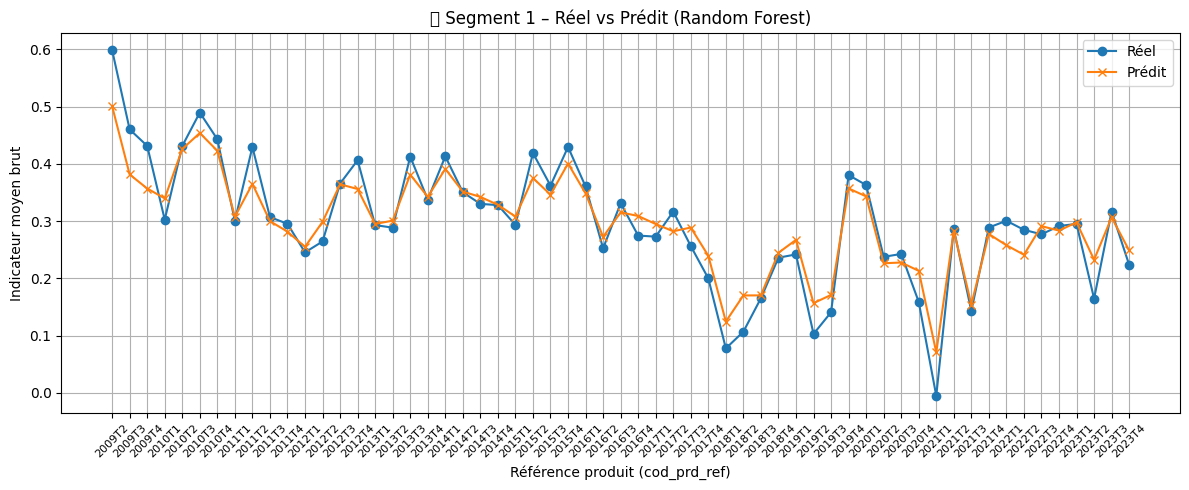

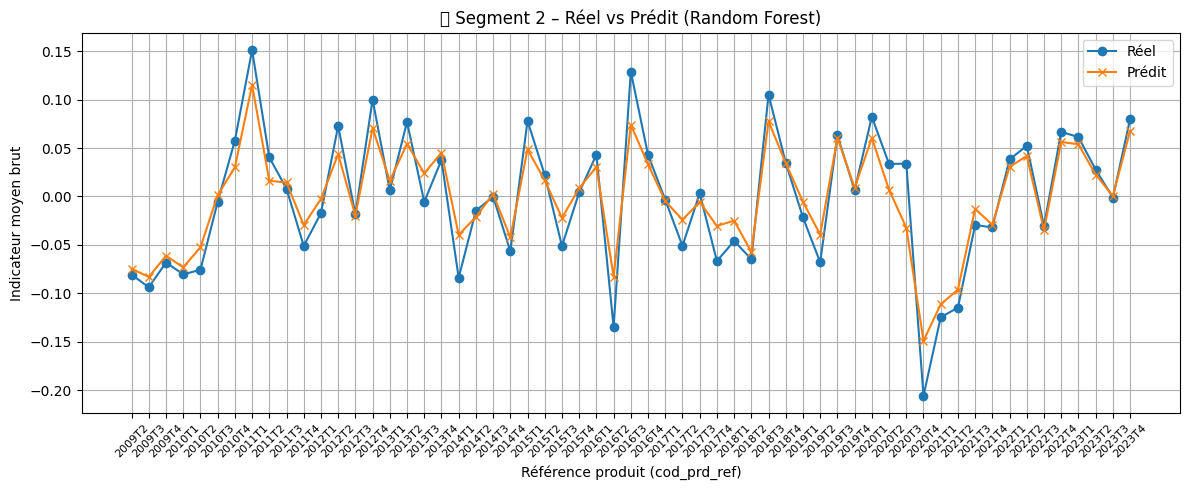

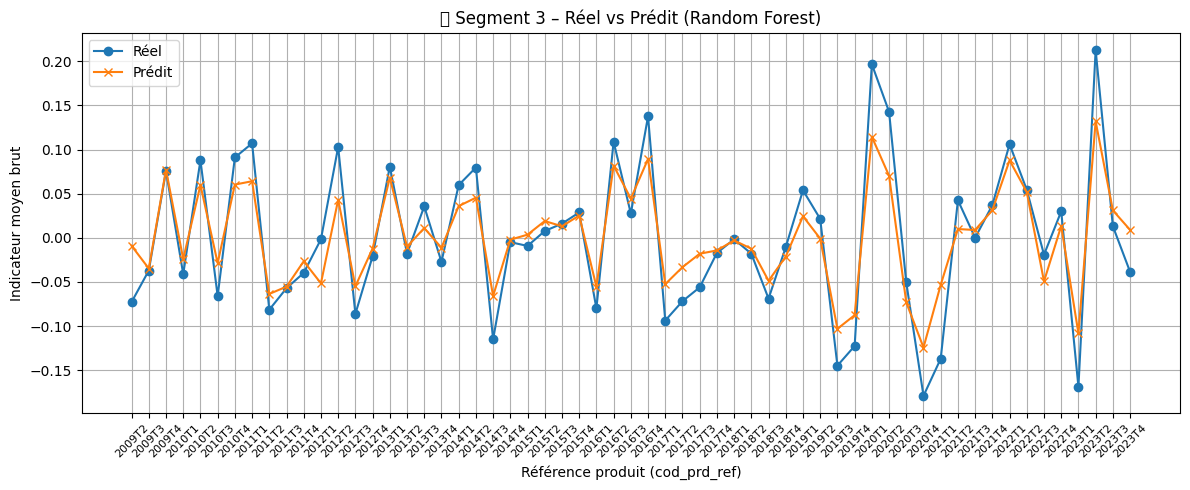

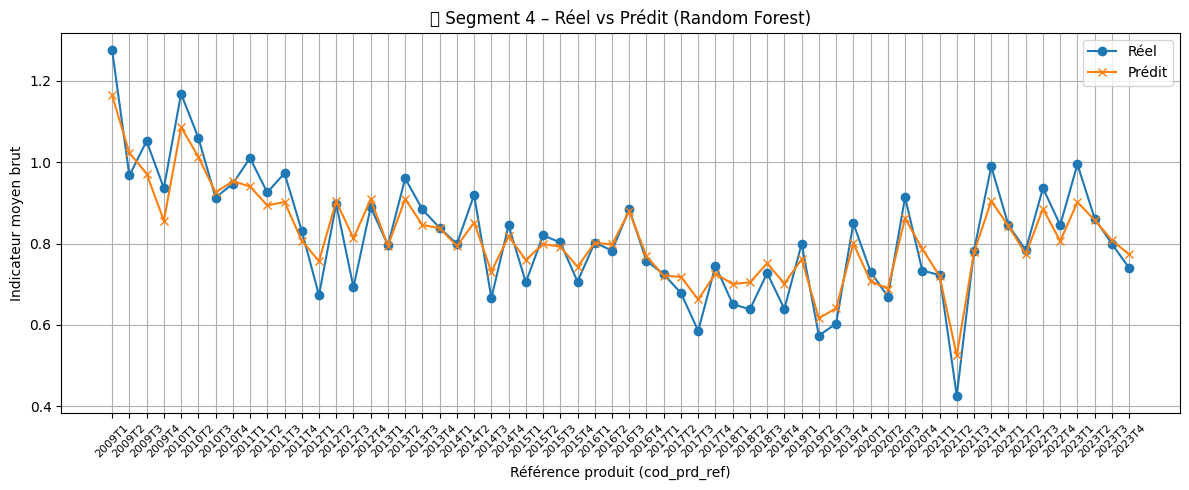

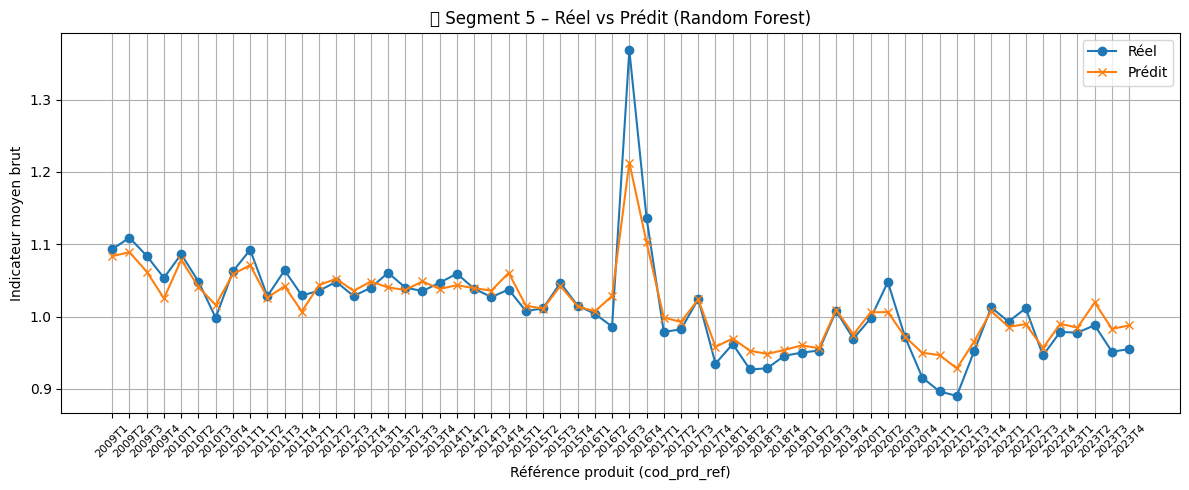

In [ ]:
import matplotlib.pyplot as plt

for i, df_pred in predictions_by_segment.items():
    plt.figure(figsize=(12, 5))
    plt.plot(df_pred["cod_prd_ref"], df_pred["Indicateur_moyen_Brut"], label="Réel", marker='o')
    plt.plot(df_pred["cod_prd_ref"], df_pred["prediction"], label="Prédit", marker='x')
    plt.title(f"📈 Segment {i} – Réel vs Prédit (Random Forest)")
    plt.xlabel("Référence produit (cod_prd_ref)")
    plt.ylabel("Indicateur moyen brut")
    plt.xticks(rotation=45, fontsize=8)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


In [ ]:
import os
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Créer le dossier si besoin
os.makedirs("models", exist_ok=True)

predictions_by_segment = {}

for i, df in segments.items():
    df = df.copy()

    # Nettoyage
    df["Indicateur_moyen_Brut"] = df["Indicateur_moyen_Brut"].astype(str).str.replace(",", ".").astype(float)
    df = df.dropna(subset=["Indicateur_moyen_Brut"])

    # Sélection des top features
    df_num = df.select_dtypes(include='number')
    corr = df_num.corr()["Indicateur_moyen_Brut"].drop("Indicateur_moyen_Brut")
    top_features = corr.abs().sort_values(ascending=False).head(5).index.tolist()

    # Données X / y
    X = df[top_features].astype(float)
    y = df["Indicateur_moyen_Brut"]
    Xy = pd.concat([X, y], axis=1).dropna()
    X = Xy[top_features]
    y = Xy["Indicateur_moyen_Brut"]

    if len(X) < 10:
        print(f"⚠️ Trop peu de données pour le segment {i}")
        continue

    # Entraînement
    model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    y_pred = model.predict(X)

    # Sauvegarde du modèle
    model_path = f"models/random_forest_segment_{i}.joblib"
    joblib.dump((model, top_features), model_path)
    print(f"💾 Modèle segment {i} sauvegardé → {model_path}")

    # Sauvegarde des prédictions pour affichage
    df_result = df.loc[X.index].copy()
    df_result["prediction"] = y_pred
    predictions_by_segment[i] = df_result

    print(f"✅ Segment {i} – R² = {r2_score(y, y_pred):.3f}")


💾 Modèle segment 1 sauvegardé → models/random_forest_segment_1.joblib
✅ Segment 1 – R² = 0.892
💾 Modèle segment 2 sauvegardé → models/random_forest_segment_2.joblib
✅ Segment 2 – R² = 0.886
💾 Modèle segment 3 sauvegardé → models/random_forest_segment_3.joblib
✅ Segment 3 – R² = 0.822
💾 Modèle segment 4 sauvegardé → models/random_forest_segment_4.joblib
✅ Segment 4 – R² = 0.883
💾 Modèle segment 5 sauvegardé → models/random_forest_segment_5.joblib
✅ Segment 5 – R² = 0.844


In [ ]:
import pandas as pd

# Charger uniquement la feuille CENT du fichier
df_raw  = pd.read_excel(r"data\Scenario_horizon3ans_propre.xlsx")

df_cent = df_raw[["date", "PIB_CENT", "IPL_CENT", "TCH_CENT", "Inflation_CENT"]].copy()
df_cent = df_cent.rename(columns={
    "PIB_CENT": "PIB",
    "IPL_CENT": "IPL",
    "TCH_CENT": "TCH",
    "Inflation_CENT": "Inflation"
})

In [ ]:
df_cent["PIB_diff1"] = df_cent["PIB"].diff()
df_cent["TCH_diff1"] = df_cent["TCH"].diff()
df_cent["Inflation_diff1"] = df_cent["Inflation"].diff()
df_cent["IPL_diff1"] = df_cent["IPL"].diff()

In [ ]:
df_cent = df_cent.dropna().reset_index(drop=True)

In [ ]:
cycle_ipl, trend_ipl = hpfilter(df_cent["IPL_diff1"].dropna(), lamb=1600)
df_cent["IPL_diff1_hp"] = cycle_ipl

In [ ]:
df_cent.columns

Index(['date', 'PIB', 'IPL', 'TCH', 'Inflation', 'PIB_diff1', 'TCH_diff1',
       'Inflation_diff1', 'IPL_diff1', 'IPL_diff1_hp'],
      dtype='object')

In [ ]:
def enrichir_macro_scenario(df):
    df = df.copy()

    # Lags
    df["PIB_lag1"] = df["PIB"].shift(1)
    df["PIB_lag2"] = df["PIB"].shift(2)

    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["TCH_diff1_lag2"] = df["TCH_diff1"].shift(2)

    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["Inflation_diff1_lag2"] = df["Inflation_diff1"].shift(2)

    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)
    df["IPL_diff1_hp_lag2"] = df["IPL_diff1_hp"].shift(2)

    # Moyennes mobiles
    df["PIB_ma3"] = df["PIB"].rolling(3).mean()
    df["PIB_ma5"] = df["PIB"].rolling(5).mean()

    df["TCH_ma3"] = df["TCH_diff1"].rolling(3).mean()
    df["TCH_ma5"] = df["TCH_diff1"].rolling(5).mean()

    df["Inflation_ma5"] = df["Inflation_diff1"].rolling(5).mean()
    df["IPL_ma5"] = df["IPL_diff1_hp"].rolling(5).mean()

    # Carrés
    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    # Interactions
    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]

    return df.dropna()


In [ ]:
# Mapping fixe des features par segment
top_features_dict = {
    1: ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'PIB_squared', 'TCH_ma3', 'TCH_ma5'],
    2: ['PIB_lag2', 'PIB_ma5', 'PIB_ma3', 'TCH_diff1_lag2', 'PIB_squared'],
    3: ['Inflation_diff1_squared', 'PIB_x_Inflation', 'PIB_ma5', 'PIB_lag1', 'PIB'],
    4: ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'Inflation_x_IPL', 'TCH_diff1_lag2', 'TCH_diff1'],
    5: ['PIB_squared', 'TCH_x_IPL', 'IPL_diff1_hp_squared', 'Inflation_x_IPL', 'TCH_diff1']
}


In [ ]:
import joblib

df_cent_enriched = enrichir_macro_scenario(df_cent)
predictions_cent = {}

for seg in range(1, 6):
    try:
        model, top_features = joblib.load(f"models/random_forest_segment_{seg}.joblib")

        X = df_cent_enriched[top_features].astype(float).dropna()
        y_pred = model.predict(X)

        df_result = df_cent_enriched.loc[X.index].copy()
        df_result["CCF_prédit"] = y_pred
        predictions_cent[seg] = df_result

        print(f"✅ Segment {seg} : {len(y_pred)} prédictions projetées.")
    
    except Exception as e:
        print(f"❌ Erreur segment {seg} : {e}")


✅ Segment 1 : 7 prédictions projetées.
✅ Segment 2 : 7 prédictions projetées.
✅ Segment 3 : 7 prédictions projetées.
✅ Segment 4 : 7 prédictions projetées.
✅ Segment 5 : 7 prédictions projetées.


✅ Segment 1 – 7 prédictions projetées


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\853099364.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


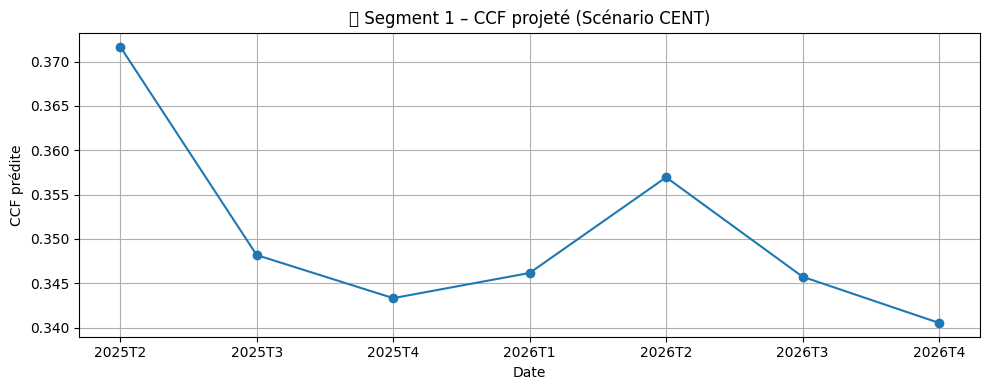

✅ Segment 2 – 7 prédictions projetées


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\853099364.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


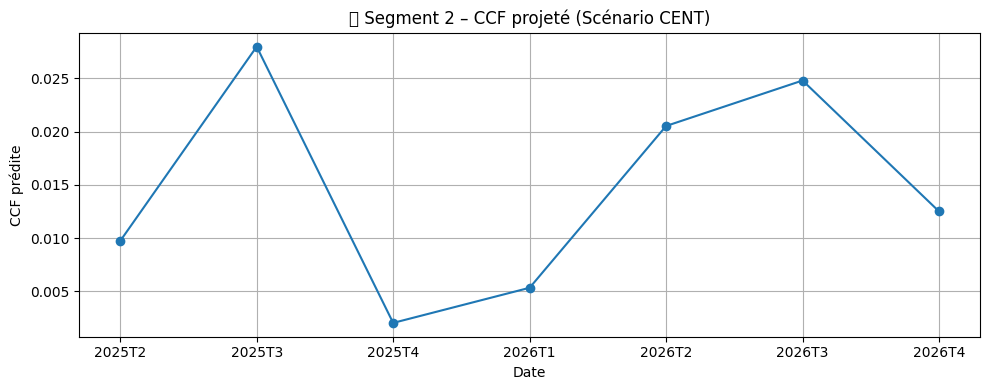

✅ Segment 3 – 7 prédictions projetées


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\853099364.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


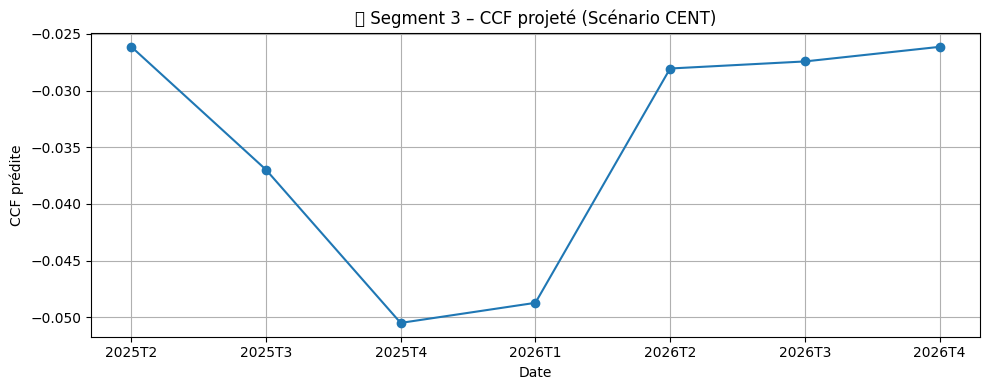

✅ Segment 4 – 7 prédictions projetées


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\853099364.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


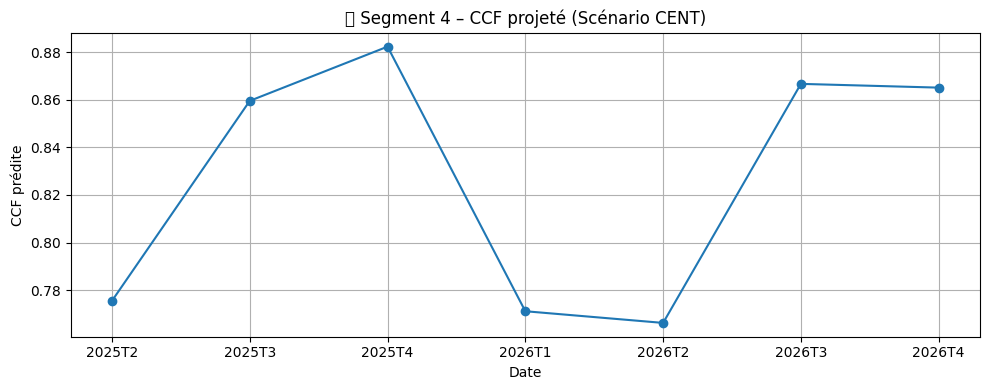

✅ Segment 5 – 7 prédictions projetées


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\853099364.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Risque de credit\.venv_RC\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


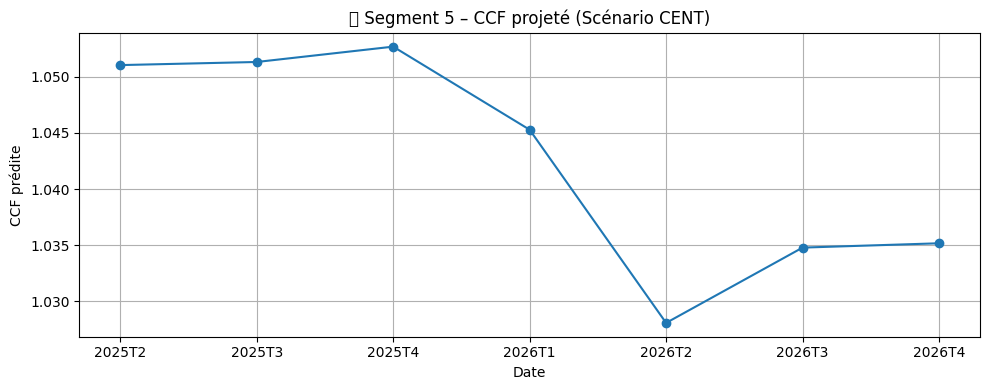

In [ ]:
import joblib
import matplotlib.pyplot as plt

df_cent_enriched = enrichir_macro_scenario(df_cent)
predictions_cent = {}

for seg in range(1, 6):
    try:
        model = joblib.load(f"models/random_forest_segment_{seg}.joblib")[0]  # ignorer top_features sauvegardées
        top_features = top_features_dict[seg]

        # Vérification que toutes les features sont là
        missing = [f for f in top_features if f not in df_cent_enriched.columns]
        if missing:
            print(f"❌ Segment {seg} – colonnes manquantes : {missing}")
            continue

        X = df_cent_enriched[top_features].astype(float).dropna()
        y_pred = model.predict(X)

        df_result = df_cent_enriched.loc[X.index].copy()
        df_result["CCF_prédit"] = y_pred
        predictions_cent[seg] = df_result

        print(f"✅ Segment {seg} – {len(y_pred)} prédictions projetées")

        # Affichage
        plt.figure(figsize=(10, 4))
        plt.plot(df_result["date"], df_result["CCF_prédit"], marker='o')
        plt.title(f"📈 Segment {seg} – CCF projeté (Scénario CENT)")
        plt.xlabel("Date")
        plt.ylabel("CCF prédite")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Segment {seg} – erreur : {e}")


In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

# === Étape 1 : fonction de transformation d’un scénario brut ===
def prepare_scenario(df_raw, prefix):
    df = df_raw[["date", f"PIB_{prefix}", f"IPL_{prefix}", f"TCH_{prefix}", f"Inflation_{prefix}"]].copy()
    df.columns = ["date", "PIB", "IPL", "TCH", "Inflation"]

    df["PIB_diff1"] = df["PIB"].diff()
    df["TCH_diff1"] = df["TCH"].diff()
    df["Inflation_diff1"] = df["Inflation"].diff()
    df["IPL_diff1"] = df["IPL"].diff()

    cycle_ipl, _ = hpfilter(df["IPL_diff1"].dropna(), lamb=1600)
    df["IPL_diff1_hp"] = cycle_ipl

    return df.dropna().reset_index(drop=True)

# === Étape 2 : enrichissement macro complet ===
def enrichir_macro_scenario(df):
    df = df.copy()

    df["PIB_lag1"] = df["PIB"].shift(1)
    df["PIB_lag2"] = df["PIB"].shift(2)

    df["TCH_diff1_lag1"] = df["TCH_diff1"].shift(1)
    df["TCH_diff1_lag2"] = df["TCH_diff1"].shift(2)

    df["Inflation_diff1_lag1"] = df["Inflation_diff1"].shift(1)
    df["Inflation_diff1_lag2"] = df["Inflation_diff1"].shift(2)

    df["IPL_diff1_hp_lag1"] = df["IPL_diff1_hp"].shift(1)
    df["IPL_diff1_hp_lag2"] = df["IPL_diff1_hp"].shift(2)

    df["PIB_ma3"] = df["PIB"].rolling(3).mean()
    df["PIB_ma5"] = df["PIB"].rolling(5).mean()

    df["TCH_ma3"] = df["TCH_diff1"].rolling(3).mean()
    df["TCH_ma5"] = df["TCH_diff1"].rolling(5).mean()

    df["Inflation_ma5"] = df["Inflation_diff1"].rolling(5).mean()
    df["IPL_ma5"] = df["IPL_diff1_hp"].rolling(5).mean()

    df["PIB_squared"] = df["PIB"] ** 2
    df["TCH_diff1_squared"] = df["TCH_diff1"] ** 2
    df["Inflation_diff1_squared"] = df["Inflation_diff1"] ** 2
    df["IPL_diff1_hp_squared"] = df["IPL_diff1_hp"] ** 2

    df["PIB_x_Inflation"] = df["PIB"] * df["Inflation_diff1"]
    df["TCH_x_IPL"] = df["TCH_diff1"] * df["IPL_diff1_hp"]
    df["Inflation_x_IPL"] = df["Inflation_diff1"] * df["IPL_diff1_hp"]

    return df.dropna().reset_index(drop=True)

# === Étape 3 : features par segment ===
top_features_dict = {
    1: ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'PIB_squared', 'TCH_ma3', 'TCH_ma5'],
    2: ['PIB_lag2', 'PIB_ma5', 'PIB_ma3', 'TCH_diff1_lag2', 'PIB_squared'],
    3: ['Inflation_diff1_squared', 'PIB_x_Inflation', 'PIB_ma5', 'PIB_lag1', 'PIB'],
    4: ['IPL_diff1_hp_squared', 'TCH_x_IPL', 'Inflation_x_IPL', 'TCH_diff1_lag2', 'TCH_diff1'],
    5: ['PIB_squared', 'TCH_x_IPL', 'IPL_diff1_hp_squared', 'Inflation_x_IPL', 'TCH_diff1']
}

# === Étape 4 : prédiction multi-scenarios ===
def predict_all_scenarios(df_raw, scenarios=["CENT", "PESS", "OPT"]):
    results = {}

    for scenario in scenarios:
        print(f"\n🔮 Scénario : {scenario}")
        df_prepared = prepare_scenario(df_raw, scenario)
        df_enriched = enrichir_macro_scenario(df_prepared)
        scenario_results = {}

        for seg in range(1, 6):
            try:
                model = joblib.load(f"models/random_forest_segment_{seg}.joblib")[0]
                top_features = top_features_dict[seg]

                X = df_enriched[top_features].astype(float).dropna()
                y_pred = model.predict(X)

                df_result = df_enriched.loc[X.index].copy()
                df_result["CCF_prédit"] = y_pred
                scenario_results[seg] = df_result

                print(f"✅ Segment {seg} – {len(y_pred)} prédictions")

                # Affichage
                plt.figure(figsize=(10, 4))
                plt.plot(df_result["date"], df_result["CCF_prédit"], marker='o')
                plt.title(f"{scenario} – Segment {seg} – CCF projeté")
                plt.xlabel("Date")
                plt.ylabel("CCF prédite")
                plt.grid(True)
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"❌ Segment {seg} – erreur : {e}")

        results[scenario] = scenario_results

    return results



🔮 Scénario : CENT
✅ Segment 1 – 7 prédictions


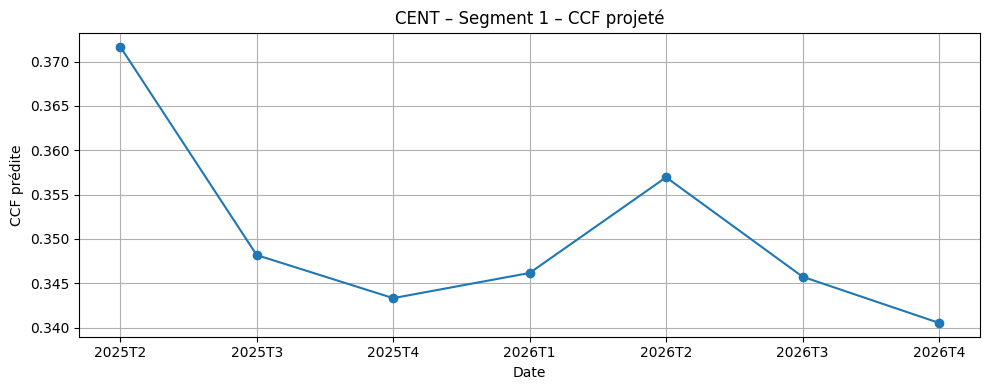

✅ Segment 2 – 7 prédictions


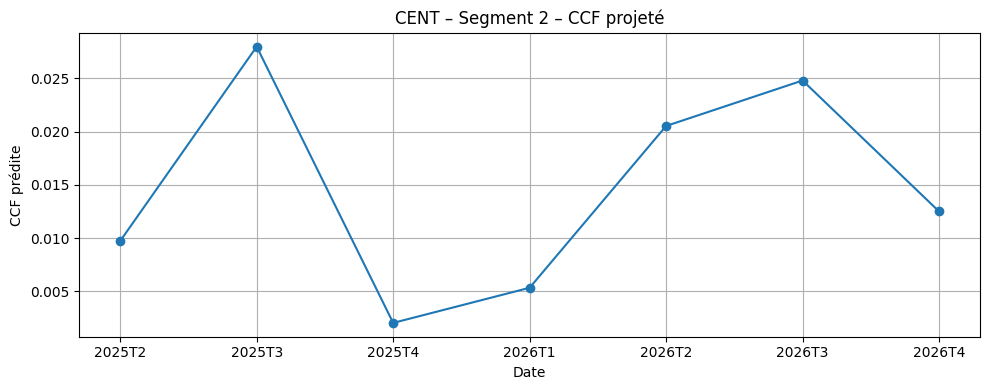

✅ Segment 3 – 7 prédictions


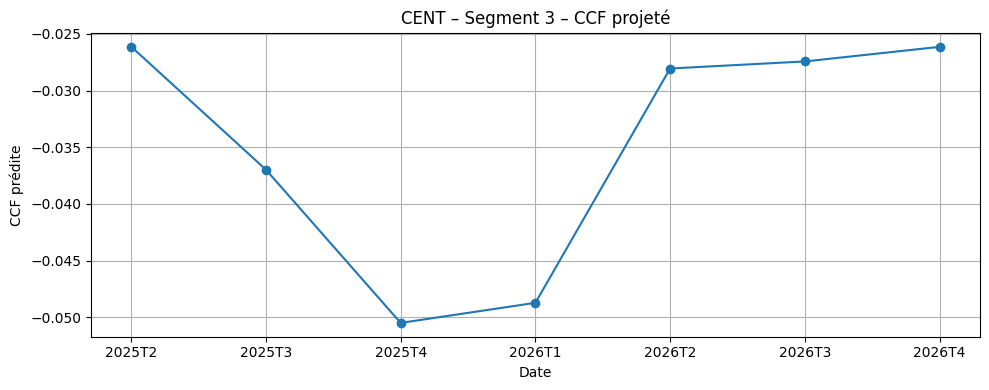

✅ Segment 4 – 7 prédictions


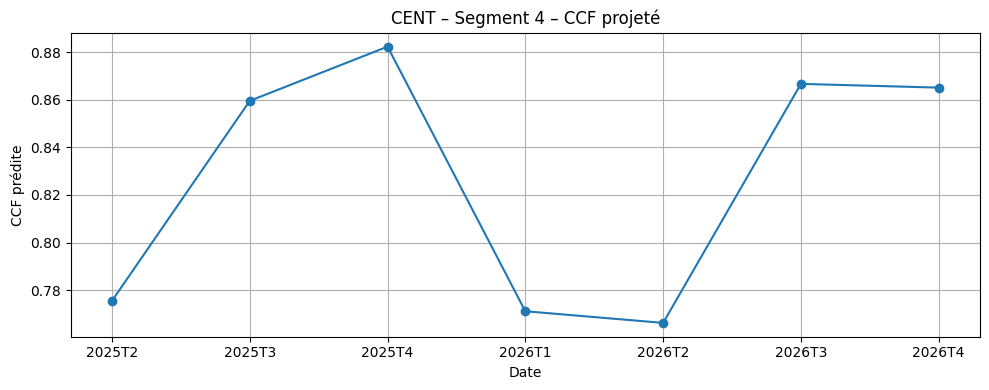

✅ Segment 5 – 7 prédictions


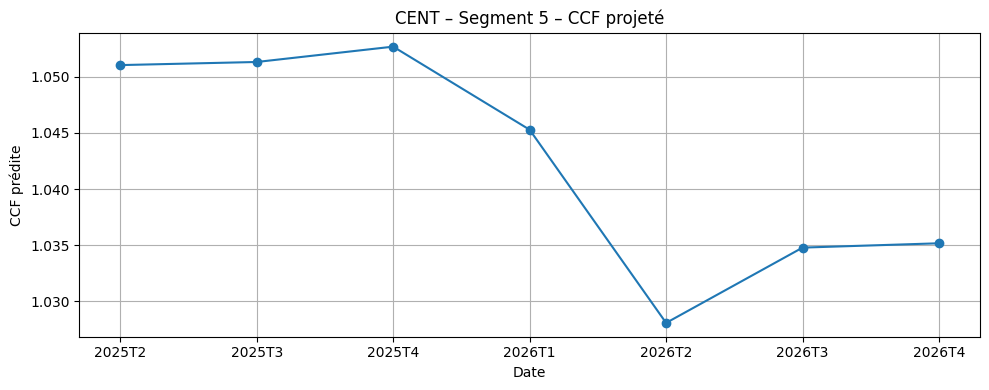


🔮 Scénario : PESS
✅ Segment 1 – 7 prédictions


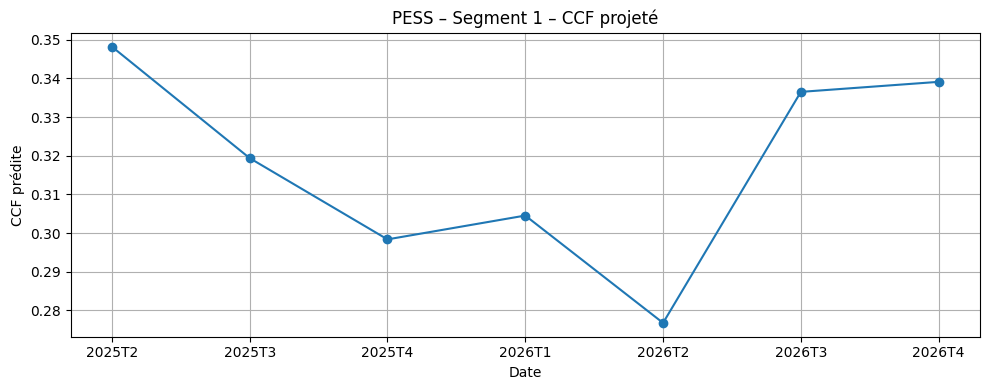

✅ Segment 2 – 7 prédictions


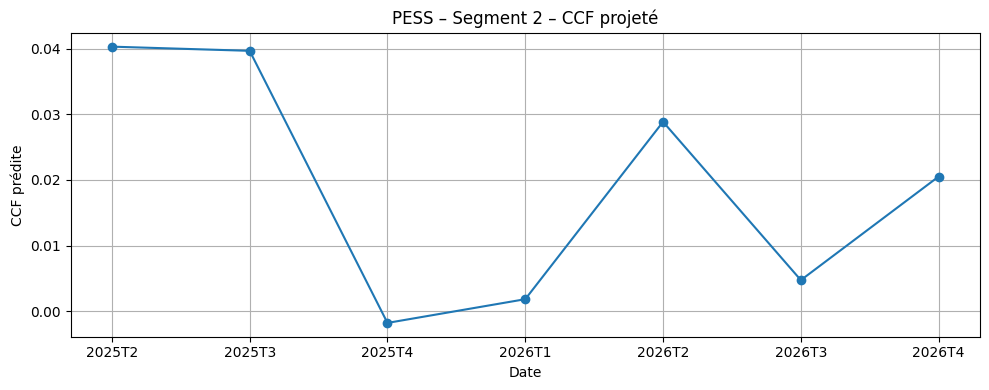

✅ Segment 3 – 7 prédictions


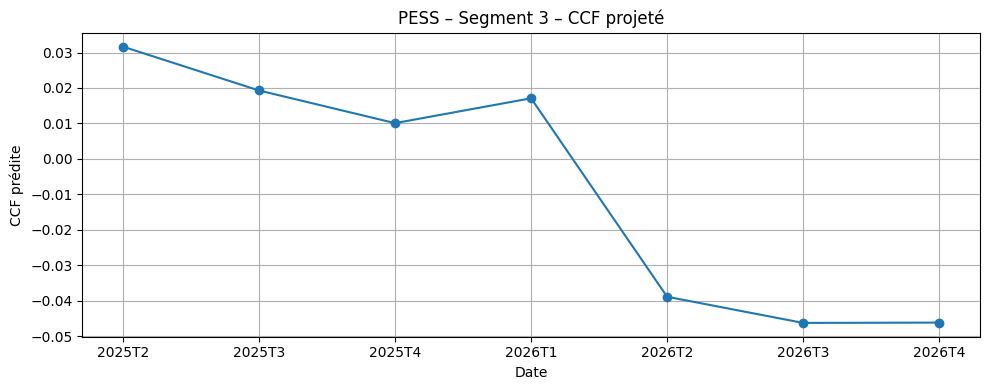

✅ Segment 4 – 7 prédictions


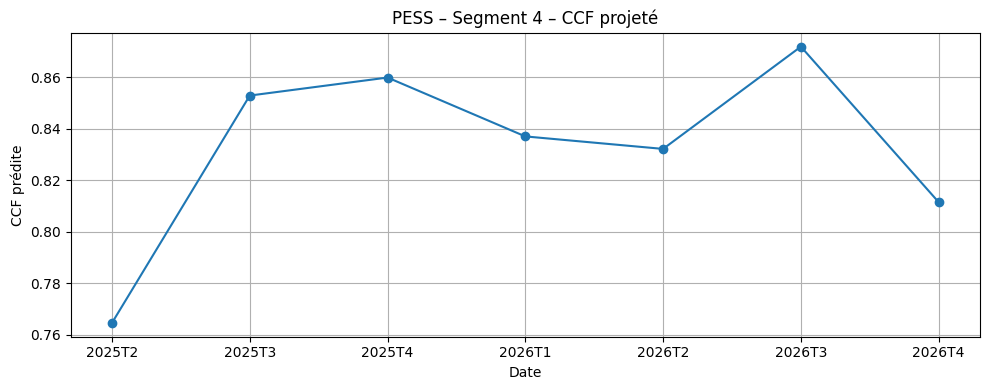

✅ Segment 5 – 7 prédictions


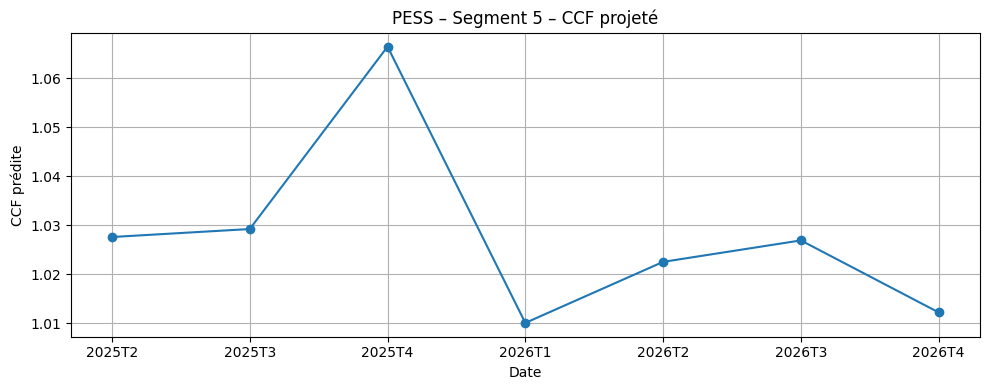


🔮 Scénario : OPT
✅ Segment 1 – 7 prédictions


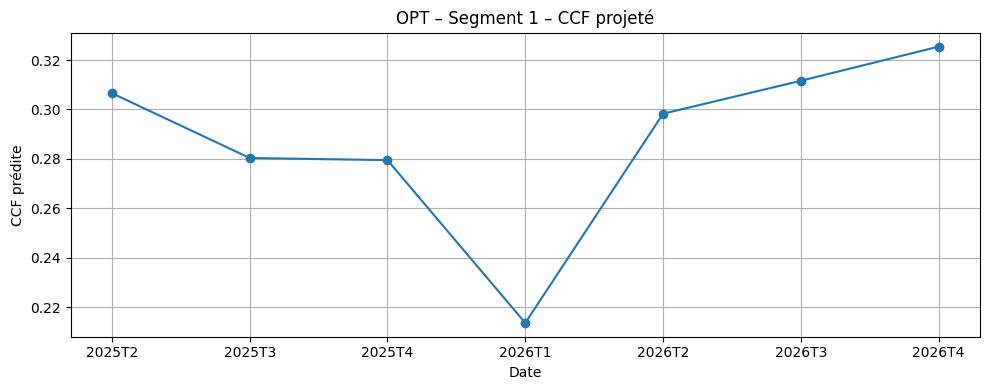

✅ Segment 2 – 7 prédictions


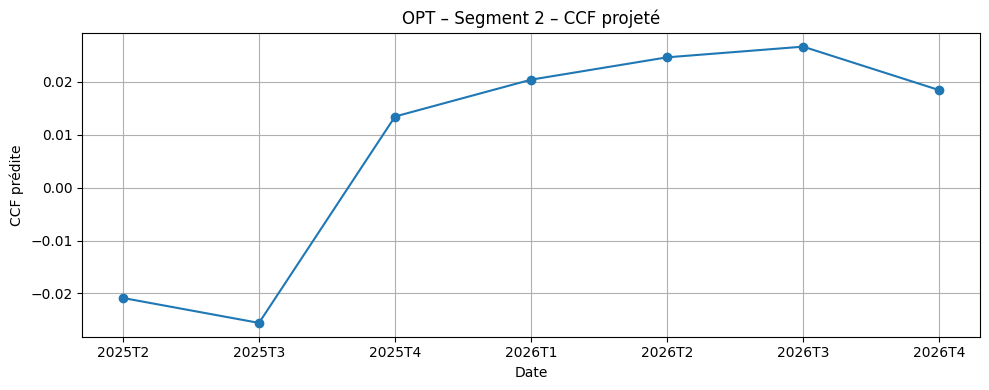

✅ Segment 3 – 7 prédictions


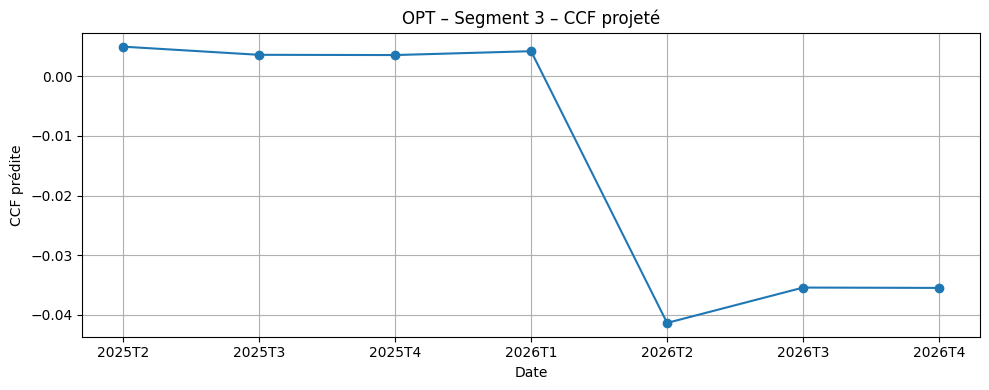

✅ Segment 4 – 7 prédictions


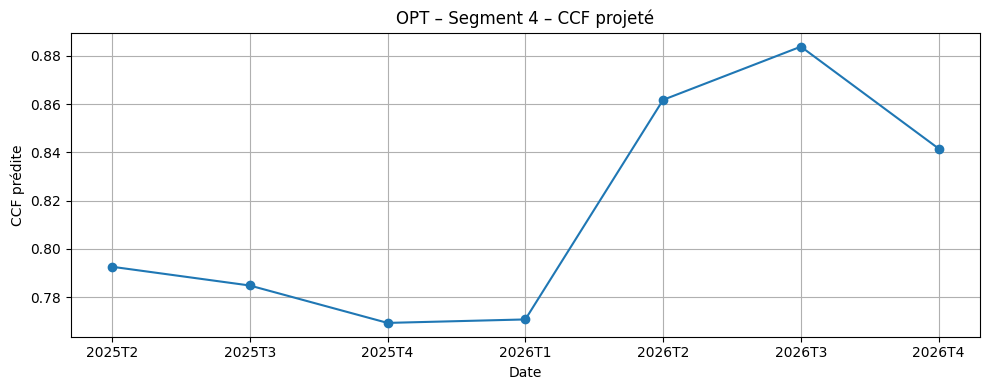

✅ Segment 5 – 7 prédictions


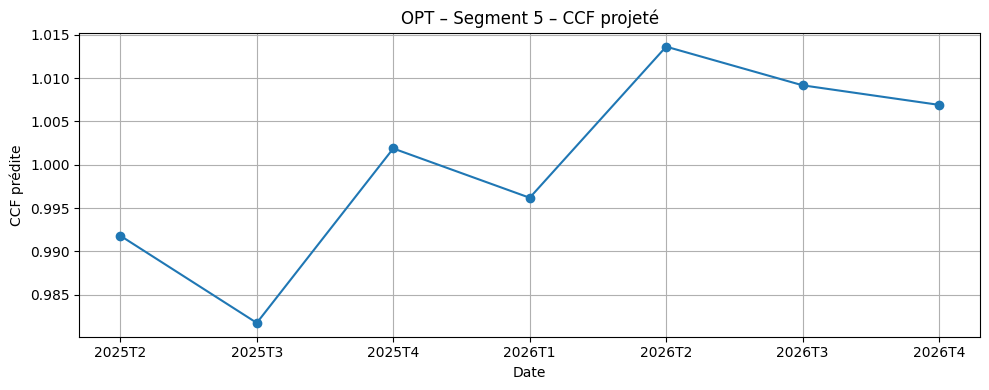

In [ ]:
# Charger le fichier macro

# Exécution multi-scenarios
results_scenarios = predict_all_scenarios(df_raw)


C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:16: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed in

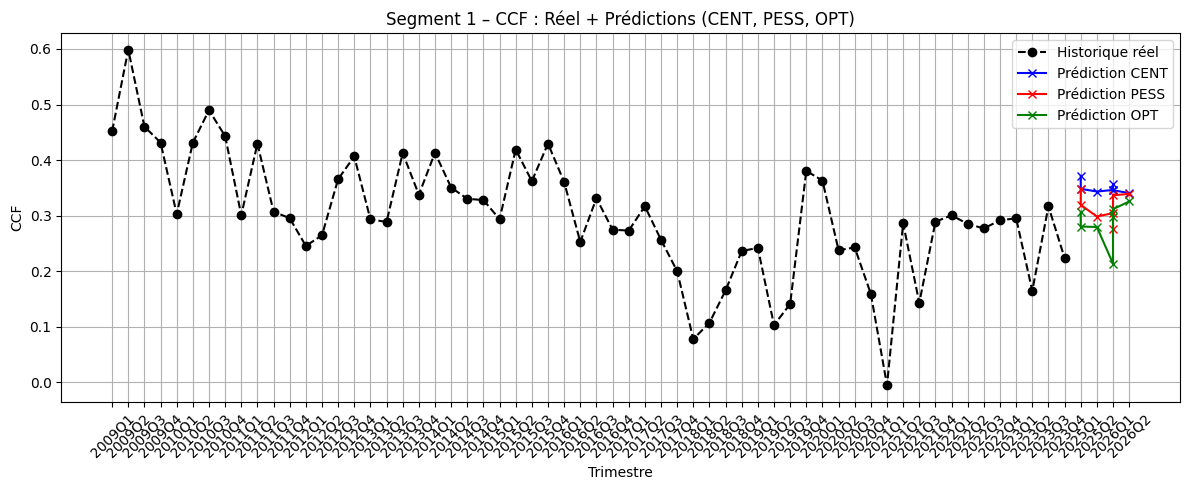

C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:16: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed in

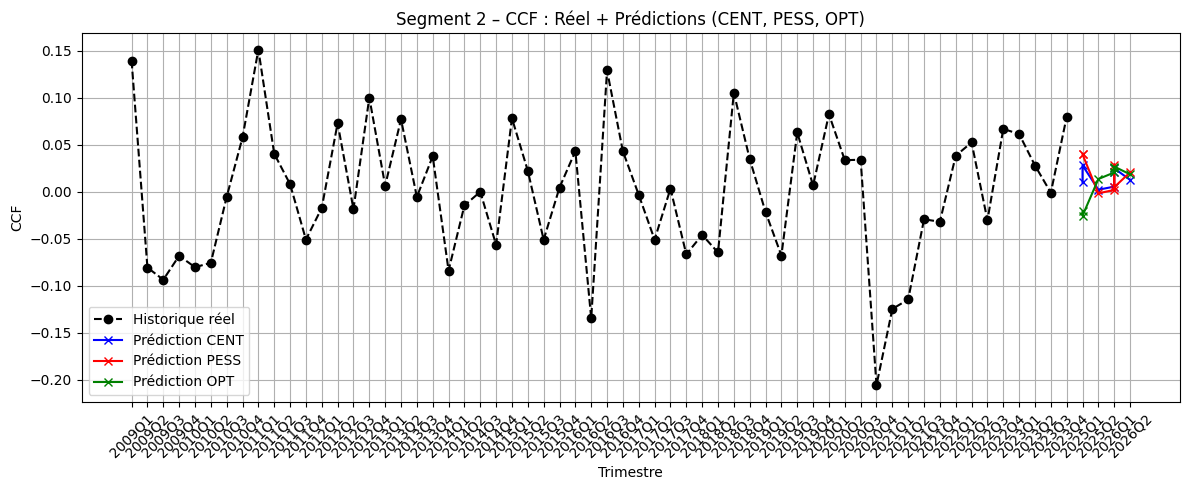

C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:16: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed in

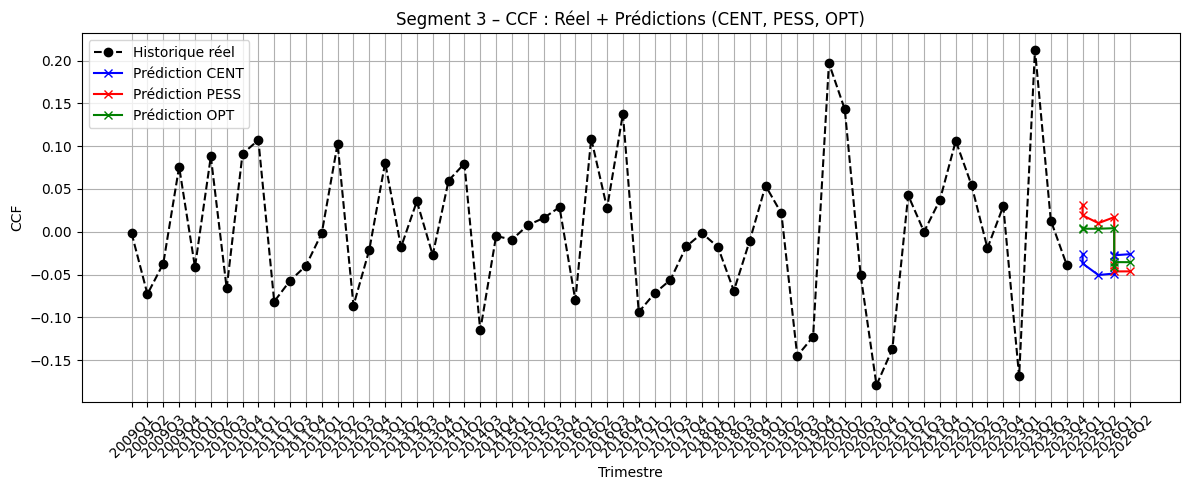

C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:16: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed in

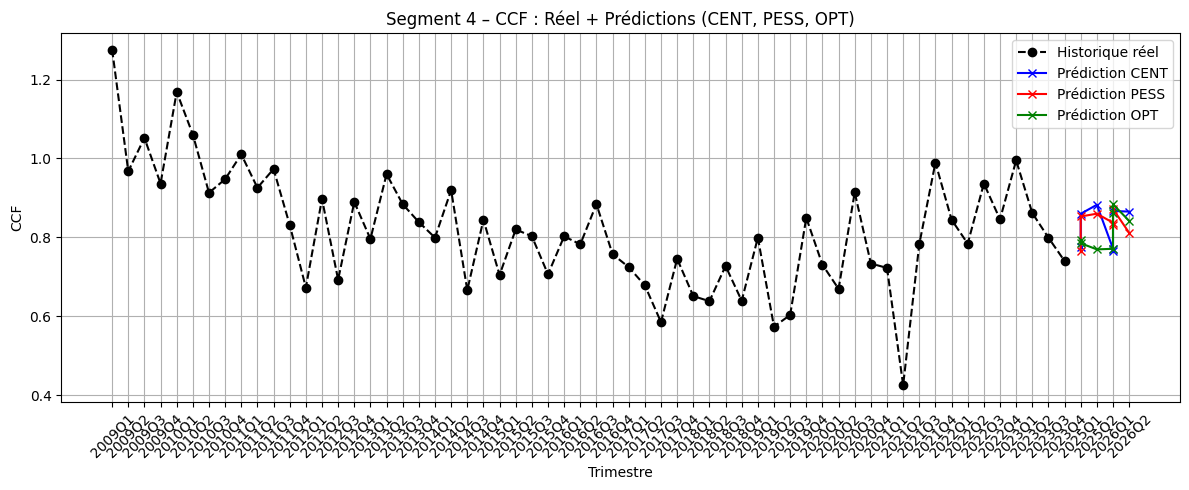

C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:16: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred["date"] = pd.to_datetime(df_pred["date"])
C:\Users\chemm\AppData\Local\Temp\ipykernel_21544\172878704.py:28: UserWarning: Could not infer format, so each element will be parsed in

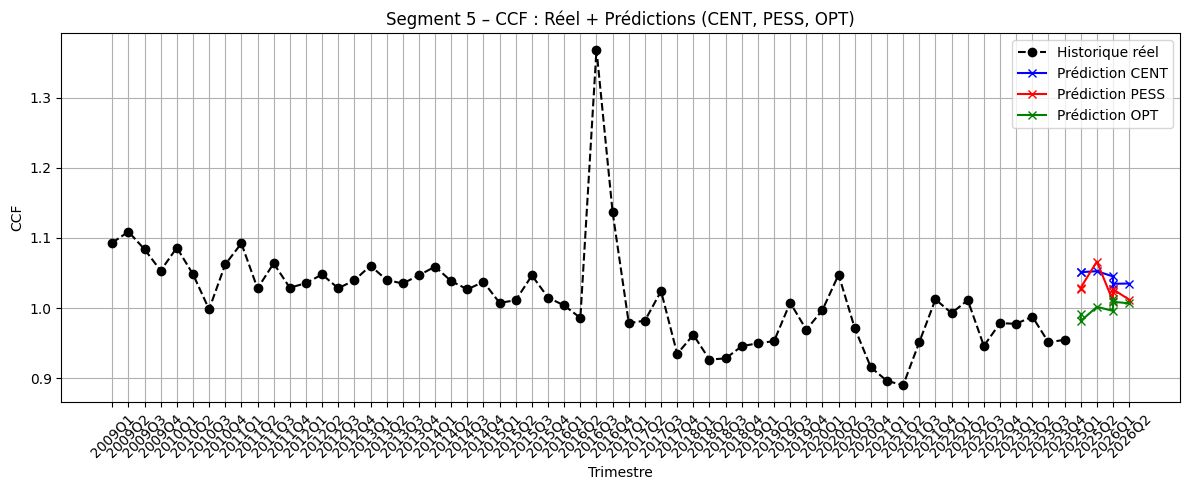

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

for seg in range(1, 6):
    fig, ax = plt.subplots(figsize=(12, 5))

    df_hist = segments[seg].copy()
    df_hist["Indicateur_moyen_Brut"] = (
        df_hist["Indicateur_moyen_Brut"]
        .astype(str).str.replace(",", ".").astype(float)
    )
    df_hist = df_hist.dropna(subset=["Indicateur_moyen_Brut"]).reset_index(drop=True)

    if "date" not in df_hist.columns:
        nb_hist = len(df_hist)
        df_hist["date"] = pd.date_range(end="2023-12-31", periods=nb_hist, freq="Q-DEC")

    df_hist["trimestre"] = pd.to_datetime(df_hist["date"]).dt.to_period("Q").astype(str)

    ax.plot(df_hist["trimestre"],
            df_hist["Indicateur_moyen_Brut"],
            label="Historique réel", marker="o", linestyle="--", color="black")

    couleurs = {"CENT": "blue", "PESS": "red", "OPT": "green"}
    for scenario in ["CENT", "PESS", "OPT"]:
        try:
            df_pred = results_scenarios[scenario][seg].copy()
            df_pred["date"] = pd.to_datetime(df_pred["date"])
            df_pred["trimestre"] = df_pred["date"].dt.to_period("Q").astype(str)

            ax.plot(df_pred["trimestre"], df_pred["CCF_prédit"],
                    label=f"Prédiction {scenario}",
                    marker="x", linestyle="-", color=couleurs[scenario])
        except Exception as e:
            print(f"⚠️ Segment {seg} – Scénario {scenario} manquant ou erreur : {e}")

    ax.set_title(f"Segment {seg} – CCF : Réel + Prédictions (CENT, PESS, OPT)")
    ax.set_xlabel("Trimestre")
    ax.set_ylabel("CCF")
    ax.grid(True)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
